In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

## Import data

In [2]:
data_dir = "../../../DATA_MAY18/spec1d/"
fname = '2-8h30m-600-spec1d.npz'

In [3]:
data = np.load(data_dir + fname) #object, flag (0, 1), wavelength. flags: 0 -> iamge, 1 -> ivar

In [4]:
def dataPrime(image, ivar):
    """Returns the ratio of data over error
    
    Parameters
    ----------
    image: 2D spectra of image
    ivar: 2D inverse variance of image
    """
    
    return np.sqrt((image**2)*ivar)

In [5]:
def Chi2Null(image, ivar):
    """Returns the null chi2 of the 2D spectra by squaring dataPrime and then summing it along column axis"""
    
    return np.sum((dataPrime(image, ivar))**2, axis = 1)

In [6]:
def wave_grid(data):
    """Returns wavegrid based on header file from data"""
    
    crval1 = float(str(data['headers'][1]).split("CRVAL1")[1].split("=")[1].split("/")[0]) #Starting value
    cdelt1 = float(str(data['headers'][1]).split("CDELT1")[1].split("=")[1].split("/")[0]) #Pixel size
    
    collapsedSpectrum = data['data_ivar'][:, 0, :]
    
    wave_grid = crval1 + cdelt1 * np.arange(collapsedSpectrum[1].shape[0])
    wave_grid *= 10 #Convert wave_grid to Angstrom from nm
    return wave_grid

In [7]:
def lambda_to_z(wavelength):
    """Converts wavelength grid to redshift grid"""
    
    separation = (3729.875-3727.092)/2 #separation between the emission lines
    lambda0 = 3727.092 + separation #Midpoint of the gaussian emission lines in restframe
    
    return (wavelength/lambda0 - 1)

In [8]:
def Window(z, wg, z_grid, window_width = 0.005):
    """Returns a range of pixel in the specified window width
    
    Parameters
    ----------
    z: Centre of the window
    wg: wave grid that needs to be windowed
    z_grid: redshift grid of the wave_grid
    window_width: size of the window in redshift space
    
    Returns
    -------
    windowed_array: windowed array of the windowing_array    
    """
    windowed_array = wg[(z_grid > (z - window_width)) & (z_grid < (z + window_width))]
    
    #Find the idx of the edges of the window
    #minidx = np.where(windowing_array == np.min(windowed_array)) 
    #maxidx = np.where(windowing_array == np.max(windowed_array))
    
    #print(np.min(windowed_array)); print(np.max(windowed_array))
    #return minidx, maxidx, windowed_array
    return windowed_array

In [9]:
def Model(z, wg2, width, Amp = 1):
    """Returns Gaussian filter model at redshift z
    
    Parameters
    ----------
    z: array of redshifts at which the model is being tested
    wg2: pixel grid of the Window
    width: width array of the Gaussian doublets
    Amp: amplitude of the Gaussian doublets
    
    Returns
    --------
    model: Gaussian models in the range of [z - window_width, z + window_width]
    """
    
    lambda_r27 = 3727.092; lambda_r29 = 3729.875 #rest frame wavelength of the [OII] doublets
    separation_r = (lambda_r29 - lambda_r27) #separation between the emission lines in rest frame
    lambda0 = lambda_r27 + separation_r/2 #Midpoint of the gaussian emission lines in restframe
    lambda_obs = lambda0*(1 + z) #Observed wavelength of of the midpoint
    Gaussian = lambda x, mean, std: (1/np.sqrt(2*np.pi*std**2))*np.exp(-((x[:, np.newaxis] - mean)/std)**2)

    model = Amp/2*(Gaussian(wg2, lambda_obs - separation_r, width) + Gaussian(wg2, lambda_obs + separation_r, width))
        
    return model

In [16]:
def SNR_calculator(data):
    z_range = np.arange(0.7, 1.6, 0.001)
    widths = np.arange(.5, 1., .1)
    
    #Read data
    image = data['data_ivar'][:, 0, :]
    ivar = data['data_ivar'][:, 1, :]
    wg = wave_grid(data)
    z_grid = lambda_to_z(wg) #Convert wavelength space to redshift space
    
    results = np.zeros((z_range.size, image.shape[0], widths.size))
    #results = np.zeros((image.shape[0], widths.size, z_range.size))
    print(results.shape)
    for i, z in enumerate(z_range):
        wg2 = Window(z, wg, z_grid)
        
        model = Model(z, wg2, widths)
        
        #Find the idx of the edges of the windows and slice the image file to multiply with modelPrime
        minidx = np.where(wg == np.min(wg2))[0][0] 
        maxidx = np.where(wg == np.max(wg2))[0][0]
        imageSliced = image[:,minidx:maxidx+1]
        imageSliced = imageSliced[:, :, np.newaxis] #Broadcasting
        ivarSliced = ivar[:,minidx:maxidx+1]
        ivarSliced = ivarSliced[:, :, np.newaxis] #Broadcasting
        imagePrimeSliced = imageSliced*np.sqrt(ivarSliced)
        
        Mprime = np.sqrt(ivarSliced)*model
        Denominator = Mprime**2
        Denominator = np.sum(Denominator, axis = 1)
        Numerator = Mprime*imagePrimeSliced
        Numerator = np.sum(Numerator, axis = 1)
        
        """
        sigmaA^(-2) = M'.M'
        A = (D'.M')/(M'.M') => (D'.M')*(sigmaA^(2))
        """
        
        Amp = Numerator/Denominator
        sigmaA = np.sqrt(1./Denominator)
        SNR = Amp/sigmaA
        
        results[i] = SNR
        #results[:,:,i] = SNR
        #print(results[i].shape)
        #print(results[:,:,i].shape)
    
    #print(results.shape)
    #results = results.reshape((image.shape[0], widths.size, z_range.size))
    #results = results.reshape((image.shape[0], z_range.size, widths.size))
    results = results.transpose([1, 2, 0]) #This maintains the indices
    print(results.shape)
    
    return z_range, results

In [15]:
from time import time

start = time()
z, SNR_tmp = SNR_calculator(data)
end = time()

tot_time = end - start
print(str(tot_time))

(901, 143, 5)


C:\Users\tanve\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
C:\Users\tanve\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide


(143, 5, 901)
1.0200245380401611


### 45000 models over 143 galaxies ~ 8.10 seconds

### -------

## Find the highest SNR models

In this section, we write a function that extracts the highest SNR models that crosses the threshold of SNR = 7 for a given galaxy and generates PDFs for us to visually inspect. We heuristically pick the number 10 to test this.

In [155]:
SNR_tmp.shape

(901, 143, 5)

(901, 5)


Text(0.5,1,'Mask: 2-8h30m-600-spec1d.npz, Slit 140')

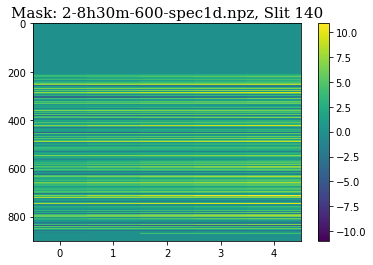

In [167]:
idx = 140
print(SNR_tmp[:, idx, :].shape)
plt.imshow(SNR_tmp[:, idx, :], aspect='auto')
plt.colorbar()
#plt.ylabel('width', fontsize = 15, fontname = 'serif')
#plt.xlabel('redshift', fontsize = 15, fontname = 'serif')
plt.title('Mask: ' + fname + ', ' + 'Slit ' + str(idx),  fontsize = 15, fontname = 'serif')
#plt.savefig("results/noreshape_ngal+w+z.pdf", dpi = 600, bbox_inches = None)

In [157]:
np.nanmax(SNR_tmp[:, idx, :])

56.2029564439547

In [158]:
np.where(np.nanmax(SNR_tmp[:, idx, :]) == SNR_tmp[:, idx, :])[0][0]

665

In [160]:
SNR_tmp[:, idx, :][np.where(np.nanmax(SNR_tmp[:, idx, :]) == SNR_tmp[:, idx, :])[0][0]]

array([41.60542069, 45.8246474 , 49.57297723, 53.0047901 , 56.20295644])

(1.0, 1.2)

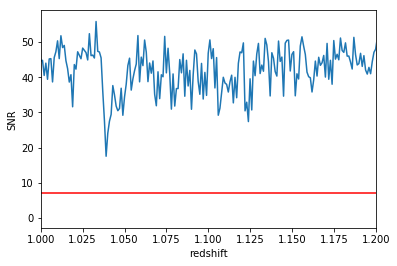

In [165]:
plt.plot(z, SNR_tmp[:, idx, 4])
#plt.plot(z, SNR_tmp[i:, idx, :, np.where(np.nanmax(SNR_tmp[idx]) == SNR_tmp[idx])[0][0]])
#plt.plot(z, SNR_tmp[i, :, 1])
#plt.plot(z, SNR_tmp[i, :, 2])
#plt.xlim([1.05, 1.2])
plt.axhline(7, c = 'red')
plt.xlabel("redshift")
plt.ylabel("SNR")
plt.xlim([1.0, 1.2])
#plt.savefig("results/1D_ngal+w+z.pdf", dpi = 600, bbox_inches = None)

(5632,)


(700, 4800)

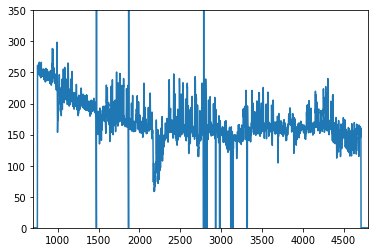

In [58]:
#idx = 

image = data['data_ivar'][:, 0, :]

imagetmp = image[68, :]
print(imagetmp.shape)

plt.plot(imagetmp)
#for i in range(len(image)):
    #plt.plot(image[i])
#ivar = data['data_ivar'][:, 1, :][0]
#image.shape
plt.ylim([0, 350])
plt.xlim([700, 4800])
#plt.subplot(2, 1, 1)
#plt.plot(image)

#plt.subplot(2, 1, 2)
#plt.plot(ivar)

### Checking raw signal-to-noise

In [40]:
image = data['data_ivar'][:, 0, :]
ivar = data['data_ivar'][:, 1, :]

In [46]:
rawsnr = image*np.sqrt(ivar)
np.where(rawsnr == np.max(rawsnr))

(array([68], dtype=int64), array([1475], dtype=int64))

Need: For every row, i.e. ngal, check if SNR > 7. If yes, then find max 10 SNR z and w for that gal and generate PDF. If not, ignore

In [61]:
tmp = np.partition(SNR_tmp, 10, axis = 0)
tmp = tmp[:,-10:]
tmp.shape

(143, 10, 5)

In [15]:
SNR_tmp.shape

(143, 9000, 5)

In [36]:
a = np.array([[ 6,  4,  10,  2,  2],
               [10,  9,  8,  7,  6]])

In [37]:
a.shape

(2, 5)

In [50]:
b = np.partition(a, 4)    # top 3 values from each row

In [51]:
b

array([[ 2,  2,  4,  6, 10],
       [ 7,  6,  8,  9, 10]])

In [52]:
b[:,-3:]

array([[ 4,  6, 10],
       [ 8,  9, 10]])

## Test with synthetic signal

Text(0,0.5,'Flux Error')

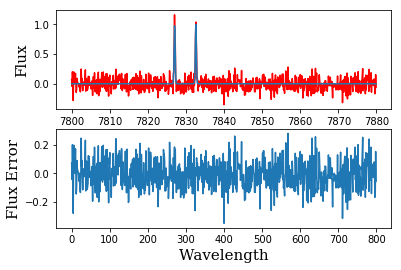

In [115]:
synthSpectra = np.arange(7800, 7880, .1) #Note that spacing must be geq the minimum linewidth, i.e. 0.1
pureData = Model(1.1, synthSpectra, .2)
errstd = 0.1
errData = np.random.normal(0, errstd, synthSpectra.shape)
synthData = pureData + errData[:, np.newaxis]

plt.subplot(2,1,1)
plt.plot(synthSpectra, synthData, c = 'red')
plt.plot(synthSpectra, pureData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux", fontname = 'serif', fontsize = 15)

plt.subplot(2,1,2)
plt.plot(errData)
plt.xlabel("Wavelength", fontname = 'serif', fontsize = 15)
plt.ylabel("Flux Error", fontname = 'serif', fontsize = 15)